In [1]:
%matplotlib inline
##########################################
# To use tensorflow follow instructions here: https://www.tensorflow.org/install/pip
# follow instructions related to creating a virtual environment with conda which can be the same 
# environment as ska3 here: https://github.com/sot/skare3/wiki/Ska3-runtime-environment-for-users
# ska is also needed
#########################################
import tensorflow as tf 
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Ska.engarchive import fetch
import Chandra.Time
from kadi import events

# Pulling and Organizing Data

In [2]:
from datetime import datetime, timedelta, time

#this is a generalized function to take the time that's given by ska
#and format is as datetime
def tme(x):
    return (datetime.strptime(Chandra.Time.DateTime(x).date, '%Y:%j:%H:%M:%S.%f'))
change_time = np.vectorize(tme)

In [3]:
#ONLY RUN THIS TO GET MORE INFO/CONSTANT PITCH TIMES
'''#here we will find the observations/time periods to use for training
#this code will most likely be used for the eq database as well
#Find observations since 2018 that have lasted 8 hours or more
dwells = events.dwells.filter(dur__gt=28800, start = '2018:001')
poss_obs = {}

#of these observations pick the ones with constant pitch
#Jean helped with best way to get constant pitch observations
for d in dwells:
    obsid = d.get_obsid()
    pitch = fetch.Msid('DP_PITCH', d.start, d.stop, stat='5min')
    poss_obs[obsid] = (np.mean(pitch.vals), d.stop, d.start)

#organizing the obs data into a useful format
obs_data = {}
for obs_id in poss_obs:
    obs = poss_obs[obs_id]
    t_form = '%Y:%j:%H:%M:%S.%f'
    start, end = datetime.strptime(obs[2], t_form), datetime.strptime(obs[1], t_form)
    dur = end-start
    obs_data[obs_id] = {'pitch': obs[0], 'start': start, 'stop': end, 'dur': dur}

df_obs = pd.DataFrame.from_dict(obs_data, orient = 'index')
#ordered = df_obs.sort_values('dur', ascending = False)'''

"#here we will find the observations/time periods to use for training\n#this code will most likely be used for the eq database as well\n#Find observations since 2018 that have lasted 8 hours or more\ndwells = events.dwells.filter(dur__gt=28800, start = '2018:001')\nposs_obs = {}\n\n#of these observations pick the ones with constant pitch\n#Jean helped with best way to get constant pitch observations\nfor d in dwells:\n    obsid = d.get_obsid()\n    pitch = fetch.Msid('DP_PITCH', d.start, d.stop, stat='5min')\n    poss_obs[obsid] = (np.mean(pitch.vals), d.stop, d.start)\n\n#organizing the obs data into a useful format\nobs_data = {}\nfor obs_id in poss_obs:\n    obs = poss_obs[obs_id]\n    t_form = '%Y:%j:%H:%M:%S.%f'\n    start, end = datetime.strptime(obs[2], t_form), datetime.strptime(obs[1], t_form)\n    dur = end-start\n    obs_data[obs_id] = {'pitch': obs[0], 'start': start, 'stop': end, 'dur': dur}\n\ndf_obs = pd.DataFrame.from_dict(obs_data, orient = 'index')\n#ordered = df_obs.

In [4]:
#df_obs.to_pickle('constant_pitch_obs.pkl')
df_obs = pd.read_pickle('constant_pitch_obs.pkl').sort_values('dur', ascending = False)

In [80]:
import itertools 
import timeit

#numpy doesn't know how to round float64, so creating a helper function
def round_vals(msid_val, round_dig):
    return (round(float(msid_val), round_dig))
rounded = np.vectorize(round_vals)

########################################
# The purpose of the two functions below is to map the right positional
# arguments to the right timing for the MSID we're looking
# logical_intervals creates intervals of time during which an MSID
# holds a certain value and select_intervals maps these intervals 
# to the times column of the MSID
#######################################

def logical_intervals(times, values):
    i = 0
    ending = len(times)
    intervals = []
    inter_values = []
    # from the itertools documentation:
    # [k for k, g in groupby('AAAABBBCCDAABBB')] --> A B C D A B
    # [list(g) for k, g in groupby('AAAABBBCCD')] --> AAAA BBB CC D
    # itertools.groupby returns A:[A,A,A,A], B:[B,B,B], C:[C,C], D:[D]
    grouped_vals = itertools.groupby(values)
    for loc_value, group in itertools.groupby(values):
        elems = len(list(group))
        begin = times[i] if i > 0 else times[i]-3600.00
        i += elems
        end = times[i] if i < ending else times[i-1]+1000000
        intervals += [(begin, end)]
        inter_values += [loc_value]
    return (intervals, inter_values)

def select_intervals(msid_data, loc_data):
    lstart = timeit.default_timer()
    msid_loc = np.empty(len(msid_data.times))
    round_loc_data = rounded(loc_data.vals, 2)
    print("rounded: ", timeit.default_timer() - lstart)
    intervals, inter_values = logical_intervals(loc_data.times, round_loc_data)
    print("logiced: ", timeit.default_timer()  - lstart)
    #here we are using the intervals from logic_intervals to create a datafram where the intervals are the index
    interval_dataframe = pd.DataFrame(inter_values, index = pd.IntervalIndex.from_tuples(intervals, closed = 'left'),
                                     columns = ['val'])
    #having intervals as the index allows us to do the below functioning
    #we give interval_dataframe a list of times and it returns the value attached to it
    print ("msid_shape: ",  msid_data.times.shape )
    print("interval_shape: ", interval_dataframe.shape)
    msid_loc = interval_dataframe.loc[msid_data.times]
    print("intervaled: ", timeit.default_timer() - lstart)
    return (msid_loc['val'].values)


In [162]:
#here we us the long pitch observations from before and build our data from around that time period
#we will start with average HRMA temp (4OAVHRMT)

fetch.data_source.set('cxc')
for i in range(len(df_obs[0:1])):
    obs = df_obs.iloc[i]
    start = (obs['start'] - timedelta(60)).strftime('%Y:%j:%H:%M:%S')
    stop = (obs['stop'] + timedelta(200)).strftime('%Y:%j:%H:%M:%S')
    print(start, stop)
    data = fetch.MSIDset(['4OAVHRMT', 'OOBTHR41','AIRU2G2I','OOBTHR08', 'DP_PITCH', 'AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4'], start, stop, filter_bad = True)
    

2018:225:22:35:32 2019:123:23:07:45


In [163]:
import numexpr as ne
def quatty(quarts):
    from Quaternion import Quat
    quat = Quat(quarts)
    return ([quat.roll, quat.yaw])


# This function takes the aoattqt data and the msid data as an MSIDset
# and returns the combined dataset
def get_all_data(msid_data, quat_data, pitch_data):
    t1998 = 883612730.816
    from mica.quaternion import normalize
    quat_vals = normalize(np.vstack([quat_data["{}{}".format('AOATTQT',i)].vals for i in [1,2,3,4]]).transpose())
    #quat_vals = pd.DataFrame(x)
    start_time = timeit.default_timer()
    quat_vect = np.apply_along_axis(quatty, 1, quat_vals)
    print ("got quat vals: ", timeit.default_timer() - start_time)
    quat_times = data['AOATTQT1'].times
    print (quat_times.shape)
    roll_v, yaw_v = quat_vect[:,0], quat_vect[:,1]
    roll_df = pd.DataFrame({'times': quat_times, 'vals': roll_v})
    yaw_df = pd.DataFrame({'times':quat_times, 'vals': yaw_v})
    msid_data_tme = msid_data.times
    msid_times = np.array(pd.to_datetime(ne.evaluate('msid_data_tme + t1998'), 
                                         unit = 's', box = False), dtype = 'datetime64[s]')
    combined_dict = {'msid_times': msid_times, 
                    'msid_vals': msid_data.vals,
                    'pitch': select_intervals(msid_data, pitch_data), 
                    'roll': select_intervals(msid_data,roll_df),
                    'yaw': select_intervals(msid_data, yaw_df)}
    return (combined_dict)

In [164]:
#reshape the data into time arrays so it looks like [val(t-n), pitch(t-n), roll(t-n),..., val(t), pitch(t)]
#we can choose and play around with n
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
#assumes order by time
def reshape_to_multi_time(data, frames=1):
    col_names = data.columns.values
    #df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence (t-n, ... t-1)
    for i in range(frames, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (name,  i)) for name in col_names]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0,1):
        cols.append(data.shift(-i))
        if i == 0: 
            names += [('%s(t)' % (name)) for name in col_names]
        else:
            names += [('%s(t+%d)' % (name, i)) for name in col_names]
    #put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    #drops rows with NaN values
    agg_full = agg.dropna()
    return agg_full

def shaping_data(combined_obs, cols, pos, frames):
    #shapes and scales data, should return dataset and scaler
    #take every 15th obs (we can change this)
    combined_obs = combined_obs[cols]
    print(combined_obs[:3])
    #take out any null values
    mask = [all(tup) for tup in zip(*[~np.isnan(combined_obs['{}'.format(i)]) for i in pos])]
    combined_obs = combined_obs[mask]
    
    from sklearn.preprocessing import MinMaxScaler

    #drop time - we have uneven time frames...
    #not sure how this will affect the algorithm but when refining will take a look
    msid_times = combined_obs['msid_times']
    raw = combined_obs.drop('msid_times', axis = 1)

    #normalize data (to be between 0 and 1) and then reshape 
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(raw)
    print ("scaled shape: ", scaled.shape)
    scaled_df = pd.DataFrame(scaled, columns = raw.columns)
    dat = reshape_to_multi_time(scaled_df, frames=frames)
    print(dat[:1])
    #we drop these values since we're not predicting them 
    drop_pos = [id + "(t)" for id in pos]
    print(drop_pos)
    shaped = dat.drop(drop_pos, axis = 1).values
    print (shaped.shape)
    return (shaped, scaler, msid_times)

In [188]:
msid_value = '4OAVHRMT'
msid_set, pitch = data[msid_value], data['DP_PITCH']
msid_df = pd.DataFrame({'times': msid.times, 'vals': msid.vals})
msid = msid_df[msid_df['vals']>290]
#att1, att2, att3, att4 = data['AOATTQT1'], data['AOATTQT2'], data['AOATTQT3'], data['AOATTQT4']
#4OAVHRMT
combined_dict = get_all_data(msid, data, pitch)
#select_intervals(msid, pitch)


got quat vals:  691.5875058751553
(17799290,)
rounded:  18.01709628570825
logiced:  21.479013046249747
msid_shape:  (556175,)
interval_shape:  (1257081, 1)
intervaled:  29.157125366851687
rounded:  16.537050009705126
logiced:  90.23274236824363
msid_shape:  (556175,)
interval_shape:  (1623231, 1)
intervaled:  99.2613976476714
rounded:  16.401742649264634
logiced:  87.4597636628896
msid_shape:  (556175,)
interval_shape:  (1592414, 1)
intervaled:  95.94353707600385


In [189]:
spacing_int = 10
combined_obs_full = pd.DataFrame(combined_dict).iloc[::spacing_int,:]
#msid_times = msid.times[::spacing_int]
combined_obs = combined_obs_full
n_features = 3
frames = 8
shaped, scaler, msid_times = shaping_data(combined_obs, ['msid_times', 'msid_vals', 'pitch', 'roll'], ['pitch', 'roll'], frames)
print (shaped.shape)

            msid_times   msid_vals   pitch   roll
0  2018-08-13 22:35:52  294.920868  139.94  243.0
10 2018-08-13 22:41:20  294.932434  139.94  243.0
20 2018-08-13 22:46:48  294.932434  139.94  243.0
scaled shape:  (55618, 3)
   msid_vals(t-8)  pitch(t-8)  roll(t-8)  msid_vals(t-7)  pitch(t-7)  \
8        0.047591    0.704092   0.675226        0.052885    0.704092   

   roll(t-7)  msid_vals(t-6)  pitch(t-6)  roll(t-6)  msid_vals(t-5)    ...     \
8   0.675226        0.052885    0.704092   0.675226        0.058179    ...      

   roll(t-3)  msid_vals(t-2)  pitch(t-2)  roll(t-2)  msid_vals(t-1)  \
8   0.675226        0.052885    0.703941   0.675226        0.047591   

   pitch(t-1)  roll(t-1)  msid_vals(t)  pitch(t)   roll(t)  
8    0.703941   0.675226      0.052885  0.703941  0.675226  

[1 rows x 27 columns]
['pitch(t)', 'roll(t)']
(55610, 25)
(55610, 25)


# Shaping Data

In [202]:
#split into train, validation and test sets
split_size = int(shaped.shape[0]/8.0)
train = shaped[:split_size*3, :]
validate = shaped[split_size*3:split_size*4, :]
test = shaped[split_size*4: , :]
print(test.shape, train.shape, validate.shape, shaped.shape)

#split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
validate_X, validate_y = validate[:, :-1], validate[:, -1]

# reshape input to be 3D tensor with shape (samples, timesteps, features]
print (train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0], frames, n_features))
test_X = test_X.reshape((test_X.shape[0], frames, n_features))
validate_X = validate_X.reshape((validate_X.shape[0], frames, n_features))
print (train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print (train_X[1])


#***********************************************************************#
# This is all for plotting purposes
# because we removed null columns we want to ignore first couple of rows,
# this is important when we are transforming back, not so much here
time_split = test.shape[0]
print(time_split)
begin_split = msid_times.shape[0] - time_split
time_train = msid_times[:split_size*3]
val_train = combined_obs.msid_vals[:split_size*3]

time_validate = msid_times[split_size*3:split_size*4]
val_validate = combined_obs.msid_vals[split_size*3:split_size*4]

time_test = msid_times[-time_split:]
val_test = combined_obs.msid_vals[-time_split:]

dash_time = hrmt_times[-time_split:]
#***********************************************************************#

(27806, 25) (20853, 25) (6951, 25) (55610, 25)
(20853, 24) (20853,) (27806, 24) (27806,)
(20853, 8, 3) (20853,) (27806, 8, 3) (27806,)
[[0.05288522 0.70409242 0.67522579]
 [0.05288522 0.70409242 0.67522579]
 [0.05817933 0.70401691 0.67522579]
 [0.05288522 0.70401691 0.67522579]
 [0.05288522 0.70401691 0.67522579]
 [0.05288522 0.70394141 0.67522579]
 [0.04759111 0.70394141 0.67522579]
 [0.05288522 0.70394141 0.67522579]]
27806


# Modeling and Validation

In [203]:
#from keras.models import Sequential
#from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras import layers, callbacks


#design network
timesteps, data_dim = train_X.shape[1], train_X.shape[2]
model = tf.keras.Sequential()
model.add(layers.LSTM(32, input_shape = (timesteps, data_dim)))
#model.add(layers.LSTM(32, return_sequences = True))
#model.add(layers.LSTM(16))
model.add(layers.Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
print (model.summary())

#fit network
epochs = 200
batch_size = 512
#checkpoint saves the best model in a file that we load later
checkpoint_path = 'saved_models/weights_best'
checkpointer = callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                         verbose = 1, save_best_only = True,
                                         save_weights_only = True, mode = 'min')

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(validate_X, validate_y), verbose=0, shuffle=False,
                   callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4608      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.08169, saving model to saved_models/weights_best

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00002: val_loss improved from 0.08169 to 0.07284, saving model to saved_models/weights_best

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00003: val_loss improved from 0.07284 to 0.05289, saving model to saved_models/weights_best

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00004: val_loss improved from 0.05289 to 0.02176, saving model 


Epoch 00046: val_loss did not improve from 0.00500

Epoch 00047: val_loss did not improve from 0.00500

Epoch 00048: val_loss did not improve from 0.00500

Epoch 00049: val_loss did not improve from 0.00500

Epoch 00050: val_loss did not improve from 0.00500

Epoch 00051: val_loss did not improve from 0.00500

Epoch 00052: val_loss did not improve from 0.00500

Epoch 00053: val_loss did not improve from 0.00500

Epoch 00054: val_loss improved from 0.00500 to 0.00453, saving model to saved_models/weights_best

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00055: val_loss did not improve from 0.00453

Epoch 00056: val_loss did not improve from 0.00453

Epoch 00057: val_loss did not improve from 0.00453

Epoch 00058: val_loss did not improve from 0.00453

Epoch 00059: val_loss did not improve from 0.00453

Epoch 00060: val_loss did not improve from 0.00453

Epoch 00061: val_loss did not improve from 0.00453

Epoch 00062: val_loss did not improve from 0.00453

Epoch 00063:


Epoch 00179: val_loss did not improve from 0.00360

Epoch 00180: val_loss did not improve from 0.00360

Epoch 00181: val_loss did not improve from 0.00360

Epoch 00182: val_loss did not improve from 0.00360

Epoch 00183: val_loss did not improve from 0.00360

Epoch 00184: val_loss did not improve from 0.00360

Epoch 00185: val_loss did not improve from 0.00360

Epoch 00186: val_loss did not improve from 0.00360

Epoch 00187: val_loss did not improve from 0.00360

Epoch 00188: val_loss did not improve from 0.00360

Epoch 00189: val_loss did not improve from 0.00360

Epoch 00190: val_loss did not improve from 0.00360

Epoch 00191: val_loss improved from 0.00360 to 0.00340, saving model to saved_models/weights_best

Consider using a TensorFlow optimizer from `tf.train`.

Epoch 00192: val_loss did not improve from 0.00340

Epoch 00193: val_loss did not improve from 0.00340

Epoch 00194: val_loss did not improve from 0.00340

Epoch 00195: val_loss did not improve from 0.00340

Epoch 00196:

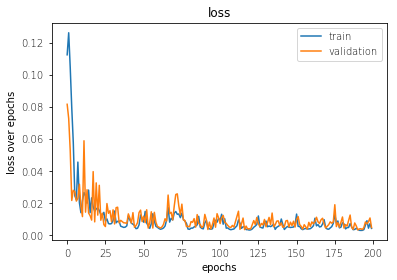

In [204]:
#plot our validation loss over epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss over epochs')
plt.legend()
plt.show()

In [205]:
#load the best model from our checkpoint
model.load_weights(checkpoint_path)

from sklearn.metrics import mean_squared_error
#use the above model to predict on our test set 
yhat = model.predict(test_X)
print("Test X shape:", test_X.shape)
print ("yhat shape", yhat.shape)
#here we are converting back to our original [var1(t-2), var2(t-2), var1(t-1), var2(t-1)] shape
test_X1 = test_X.reshape((test_X.shape[0], timesteps*data_dim))
print("Test X1 shape:", test_X1.shape)
#number of predictive variables
p_var = n_features -1
#invert scaling from 0 to 1 for forecast
#here we need to return to our original form of hrma_temp(predicted) and pitch(actual)
inv_yhat = np.concatenate((yhat, test_X1[:,-p_var:]), axis = 1)
inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_ypred = inv_yhat1[:,0]

#invert scaling from 0 to 1 for 
test_y1 = test_y.reshape((len(test_y), 1))
#here we return to our original form of hrma_temp(actual) and pitch(actual)
inv_y = np.concatenate((test_y1, test_X1[:,-p_var:]), axis = 1)
inv_y1 = scaler.inverse_transform(inv_y)
inv_yactual= inv_y1[:,0]
rmse = np.sqrt(mean_squared_error(inv_yactual, inv_ypred))
#here I'm using Mean Squared Error but obvi we can change this
print('Test RMSE: %.3f' % rmse)

Test X shape: (27806, 8, 3)
yhat shape (27806, 1)
Test X1 shape: (27806, 24)
Test RMSE: 0.009


In [216]:
#here we will plot all graphs
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, export_png
from bokeh.models import DatetimeTickFormatter
from bokeh.layouts import column, gridplot
output_notebook()
p = figure(title = ('Predicted vs Actual {}'.format(msid_value)), x_axis_label = 'time', 
           y_axis_label = 'temp', x_axis_type = "datetime")
#plot actual and predicted temperature vs. time
#p.circle(time_test, inv_yactual, legend="actual")
print (len(time_test))
p.circle(time_test, inv_ypred, legend="predicted", color = 'red', fill_alpha = 0.5, line_width = 0.01)
p.circle(time_train, val_train, legend = 'training', color = 'green', fill_alpha = 0.5, line_width = 0.01)
p.circle(time_validate, val_validate, legend = 'validation', color = 'blue', fill_alpha = 0.5, line_width = 0.01)
p.xaxis.formatter = DatetimeTickFormatter(
                                minutes = ["%Y:%j:%H:%M"],
                                hours = ["%Y:%j:%H"],
                                hourmin = ["%Y:%j:%H:%M"],
                                days = ["%Y:%j"]
                        )
show(p)
export_png(p, '{}_breakdown_plot.png'.format(msid_value))

Loading BokehJS ...

27806


/scratch1/miniconda3/envs/ska3/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


'/scratch1/hrma_tests/4OAVHRMT_breakdown_plot.png'

In [217]:
import math 
size = 450

##########################
# Plotting Predicted vs Actual
#x axis is time, y axis is temperatures
##########################
p = figure(title = ('Predicted vs Actual {}'.format(msid_value)), x_axis_label = 'time', 
           y_axis_label = 'temp', x_axis_type = "datetime", plot_height = size, plot_width = size)
#plot actual and predicted temperature vs. time
#p.circle(time_test, inv_yactual, legend="actual")
p.circle(time_test, inv_ypred, legend="predicted", color = 'red')

p.circle(time_test, inv_yactual, legend = 'original', color = 'green', fill_alpha = 0.2, line_width = 0.01)
p.xaxis.formatter = DatetimeTickFormatter(
                                minutes = ["%Y:%j:%H:%M"],
                                hours = ["%Y:%j:%H"],
                                hourmin = ["%Y:%j:%H:%M"],
                                days = ["%Y:%j"]
                        )
p.xaxis.major_label_orientation = math.pi/4

print ()

#########################
# Plotting Model Error which is just actual y value minus test y value
# x axis is time, y axis is error 
#########################
errors =  inv_yactual - inv_ypred
one_perc = np.quantile(errors, 0.01)
nn_perc = np.quantile(errors, .99)
print (one_perc, nn_perc)
scale = np.ptp(inv_yactual)/2.0
print(scale)
e = figure(title = ('Model Error (Actual - Test) {}'.format(msid_value)), x_axis_label = 'time', 
           y_axis_label = 'error (deg)', x_axis_type = "datetime", plot_height = 200, plot_width = size,
           y_range = (-scale, scale), x_range = p.x_range)
#plot actual and predicted temperature vs. time
#p.circle(time_test, inv_yactual, legend="actual")
e.circle(time_test, errors, color = 'green', line_width = 0.05)
print(time_test.shape, errors.shape)
e.xaxis.formatter = DatetimeTickFormatter(
                                minutes = ["%Y:%j:%H:%M"],
                                hours = ["%Y:%j:%H"],
                                hourmin = ["%Y:%j:%H:%M"],
                                days = ["%Y:%j"]
                        )
e.xaxis.major_label_orientation = math.pi/4

#########################
# Plotting Error by Temperature
# 
#########################
m = figure(title = 'Actual vs. Model Error {}'.format(msid_value), x_axis_label = 'error (deg)', 
           y_axis_label = 'temp',  x_range = (-scale, scale), y_range = p.y_range,
          plot_height = size, plot_width = size)
#plot actual and predicted temperature vs. time
#p.circle(time_test, inv_yactual, legend="actual")
m.circle(errors, inv_yactual, color = 'green', line_width = 0.01)


def make_histogram(title, hist, edges, x):
    h = figure(title = title, tools = ' ',  x_range = m.x_range, plot_height = 200, plot_width = size)
    h.quad(top = hist, bottom = 0, left = edges[:-1], right = edges[1:],
          line_color = "white", fill_color = "green")
    h.y_range.start = 0
    return h

hist, edges = np.histogram(errors, density = True, bins = 25)
hist = hist*1.0/sum(hist)
histogram = make_histogram("Error Distribution {}".format(msid_value), hist, edges, errors)

show(gridplot([[p,m],[e, histogram]]))




-0.022478769397957874 0.01587536383267434
0.1689910888671875
(27806,) (27806,)


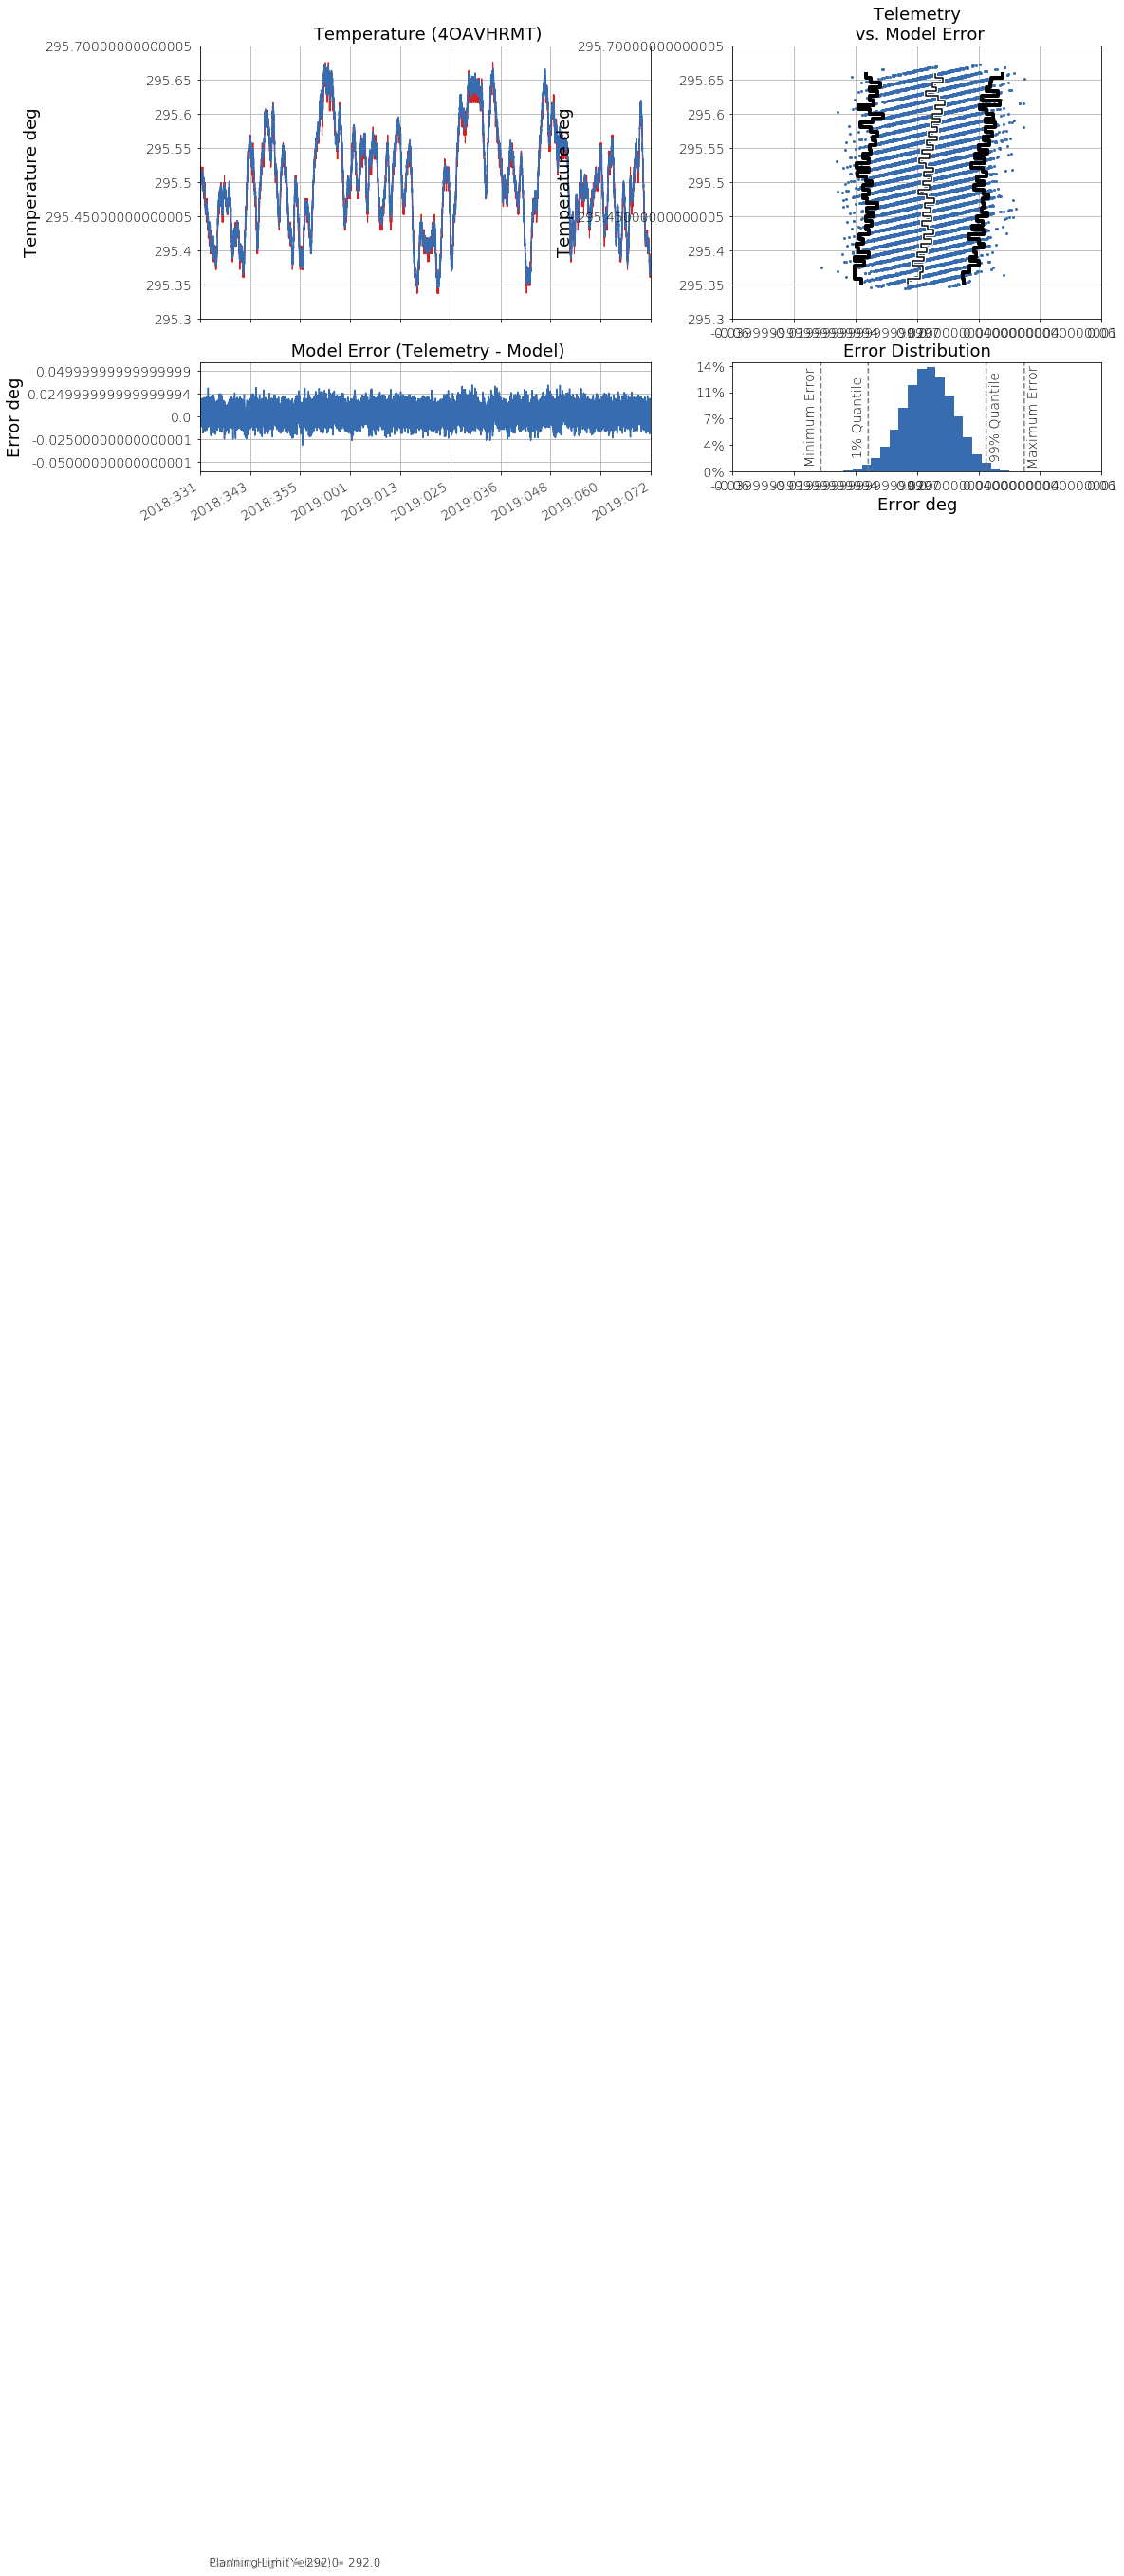

In [211]:
import xijafit.xijafit.dashboard as dash
modellimits = {'units': '', 'caution_high': 292, 'planning_limit': 292}
dash.dashboard(inv_yactual, inv_ypred, dash_time, modellimits, modelname='', msid=msid_value, yplotlimits=[295.3,295.7], errorplotlimits=[-0.06, 0.06])

In [ ]:
'''def logical_intervals_old(times, values):
    print (values[:5])
    i = 0
    ending = len(times)
    intervals = []
    # [k for k, g in groupby('AAAABBBCCDAABBB')] --> A B C D A B
    # [list(g) for k, g in groupby('AAAABBBCCD')] --> AAAA BBB CC D
    #itertools.groupby returns A:[A,A,A,A], B:[B,B,B], C:[C,C], D:[D]
    start = timeit.default_timer()
    print("logic start:", start)
    grouped_vals = itertools.groupby(values)
    print("grouped: ", timeit.default_timer() - start)
    for loc_value, group in itertools.groupby(values):
        elems = len(list(group))
        begin = times[i] if i > 0 else times[i]-3600.00
        i += elems
        end = times[i] if i < ending else times[i-1]
        intervals += [(loc_value, begin, end)]
    print("done loop: ", timeit.default_timer() - start)
    return (intervals)


def select_intervals_old(msid_data, loc_data):
    lstart = timeit.default_timer()
    print("select start:", lstart)
    msid_loc = np.empty(len(msid_data.times))
    round_loc_data = rounded(loc_data.vals)
    print("rounded: ", timeit.default_timer() - lstart)
    intervals = logical_intervals_old(loc_data.times, round_loc_data)
    print("logiced: ", timeit.default_timer()  - lstart)
    for interval in intervals:
        begin, end = interval[1], interval[2]
        msid_bool = ((msid_data.times >= begin) & (msid_data.times <= end))
        msid_loc[msid_bool] = interval[0]
    print("intervaled: ", timeit.default_timer() - lstart)
    return (msid_loc)'''